In [ ]:
pip install yfinance

In [74]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model

In [75]:
# path to datafiles 
spx_file = pd.read_csv('/Users/apple/Desktop/PG/Summer-24/Fintech/spx-usd-max.csv')
btc_file = pd.read_csv('/Users/apple/Desktop/PG/Summer-24/Fintech/btc-usd-max.csv')

In [76]:
def load_and_preprocess_spx_data(spx_file):
    df_spx = spx_file
    df_spx.fillna(method='ffill', inplace=True)  # Handle missing data
    print(df_spx.head())  # Verify the data is loaded
    return df_spx[['price', 'market_cap', 'total_volume']]


In [77]:
def load_and_preprocess_btc_data(btc_file_file):
    df_btc = btc_file
    df_btc.fillna(method='ffill', inplace=True)  # Handle missing data
    print(df_btc.head())  # Verify the data is loaded
    return df_btc[['price', 'market_cap', 'total_volume']]

In [78]:
# Load and preprocess data
# def load_and_preprocess_data(spx_file: str, btc_file: str) -> pd.DataFrame:
#     # Load SPX data
#     df_spx = spx_file
#     # Load BTC data
#     df_btc = btc_file
#     # Preprocess BTC Data
#     df_btc.fillna(method='ffill', inplace=True)
#     btc_features = df_btc[['btc_price', 'btc_market_cap', 'btc_total_volume']]
    
#     # Preprocess SPX Data
#     df_spx.fillna(method='ffill', inplace=True)
#     spx_features = df_spx[['spx_price', 'spx_market_cap', 'spx_total_volume']]
    
#     # Fill missing BTC data (if any)#
#     for col in ['btc_price', 'btc_market_cap', 'btc_total_volume']:
#         df_btc[col].fillna(method='ffill', inplace=True)
    
#     # Calculate additional features
#     for asset in ['', 'btc_']:
#         df_btc[f'{asset}price_change'] = df_btc[f'{asset}price'].pct_change()
#         df_btc[f'{asset}price_ma7'] = df_btc[f'{asset}price'].rolling(window=7).mean()
#         df_btc[f'{asset}price_ma30'] = df_btc[f'{asset}price'].rolling(window=30).mean()
#         df_btc[f'{asset}rsi'] = calculate_rsi(df_btc[f'{asset}price'])
    
#     df_btc.dropna(inplace=True)
#     return btc_features, spx_features

# Calculate RSI
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Load stock market data
def load_stock_data(start_date: str, end_date: str) -> pd.DataFrame:
    tickers = ['^GSPC', '^IXIC', 'GC=F']  # S&P 500, NASDAQ, Gold
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
    stock_data.columns = ['SP500', 'NASDAQ', 'Gold']
    return stock_data

In [79]:
# Correlation analysis
def perform_correlation_analysis(df: pd.DataFrame) -> None:
    corr_matrix = df[['price', 'btc_price', 'SP500', 'NASDAQ', 'Gold']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [80]:
# Update the prepare_data_for_transformer function
def prepare_data_for_transformer(df: pd.DataFrame, seq_length: int) -> Tuple[torch.Tensor, torch.Tensor, MinMaxScaler]:
    features = ['price', 'market_cap', 'total_volume', 'btc_price', 'btc_market_cap', 'btc_total_volume',
                'price_change', 'price_ma7', 'price_ma30', 'rsi',
                'btc_price_change', 'btc_price_ma7', 'btc_price_ma30', 'btc_rsi',
                'SP500', 'NASDAQ', 'Gold']
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:(i + seq_length)])
        y.append(scaled_data[i + seq_length, 0])  # 0 index is the SPX price
    
    return torch.FloatTensor(X), torch.FloatTensor(y), scaler

# Update the TransformerModel
class TransformerModel(nn.Module):
    def __init__(self, input_dim: int, d_model: int, nhead: int, num_layers: int):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])  # Use the last sequence element for prediction

In [81]:
# Update the predict_future function
def predict_future(model: nn.Module, last_sequence: torch.Tensor, 
                   scaler: MinMaxScaler, num_days: int) -> np.ndarray:
    model.eval()
    predictions = []
    current_sequence = last_sequence.clone()
    
    for _ in range(num_days):
        with torch.no_grad():
            pred = model(current_sequence.unsqueeze(0))
        predictions.append(pred.item())
        current_sequence = torch.roll(current_sequence, -1, dims=0)
        current_sequence[-1, 0] = pred.item()
    
    # Inverse transform predictions
    predictions = np.array(predictions).reshape(-1, 1)
    dummy_array = np.zeros((len(predictions), scaler.scale_.shape[0]))
    dummy_array[:, 0] = predictions.flatten()
    predictions = scaler.inverse_transform(dummy_array)[:, 0]
    
    return predictions

In [82]:


# Train the model
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                epochs: int, lr: float) -> nn.Module:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred.squeeze(), y_batch).item()
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(val_loader):.4f}')
    
    return model


In [ ]:
print(spx_file.columns)

In [ ]:
# Updated main function
def main(): 
   # Load and preprocess SPX and BTC data separately
    spx_data = load_and_preprocess_spx_data(spx_file)
    btc_data = load_and_preprocess_btc_data(btc_file)
    
    # Perform further processing (like correlation or other analysis)
    # Make sure spx_data and btc_data are used properly as separate features

    # Prepare SPX and BTC data for the transformer
    X_btc, X_spx = prepare_data_for_transformer(btc_data, spx_data)


    
    # Load stock market data
    stock_data = load_stock_data(df.index.min(), df.index.max())
    df = df.join(stock_data)
    
    # Perform correlation analysis
    perform_correlation_analysis(df)
    
    # Prepare data for transformer model
    seq_length = 60
    X, y, scaler = prepare_data_for_transformer(df, seq_length)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
    

# Define BTC and SPX as separate inputs
    df_btc = Input(shape=(btc_features.shape[1],))
    df_spx = Input(shape=(spx_features.shape[1],))

# Concatenate the inputs to merge them
    merged_input = concatenate([df_btc, df_spx])

# Pass the merged input through the model
    x = TransformerLayer(...)(merged_input)
    output = Dense(1)(x)

# Define the model
    model = Model(inputs=[df_btc, df_spx], outputs=output)



    # Initialize and train the model
    input_dim = X.shape[2]
    model = TransformerModel(input_dim, d_model=64, nhead=4, num_layers=2)
    model = train_model(model, train_loader, val_loader, epochs=50, lr=0.001)
    
    # Evaluate the model
    model.eval()
    test_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            test_loss += criterion(y_pred.squeeze(), y_batch).item()
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')
    
    # Make future predictions
    last_sequence = X[-1]
    future_predictions = predict_future(model, last_sequence, scaler, num_days=365)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-365:], df['price'].iloc[-365:], label='Historical SPX Price')
    plt.plot(pd.date_range(start=df.index[-1], periods=366, freq='D')[1:], future_predictions, label='Predicted SPX Price')
    plt.title('SPX Price Prediction for Next 12 Months')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

## Attempt 2

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [8]:
# Load the data
df = pd.read_csv('/Users/apple/Desktop/PG/Summer-24/Fintech/spx-usd-max.csv')
df['snapped_at'] = pd.to_datetime(df['snapped_at'])
df.set_index('snapped_at', inplace=True)

# Calculate additional features
def calculate_ma(data, window):
    return data['price'].rolling(window=window).mean()

def calculate_rsi(data, window):
    delta = data['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['MA5'] = calculate_ma(df, 5)
df['MA10'] = calculate_ma(df, 10)
df['MA20'] = calculate_ma(df, 20)
df['RSI'] = calculate_rsi(df, 14)

# Drop rows with NaN values
df.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Split the data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

In [9]:
print(X_train.shape[2])

7


In [16]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead, dropout):
        super(TransformerModel, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # (seq_len, batch, input_dim)
        x = self.transformer(x)
        x = x[-1]  # Take the last output
        return self.fc(x)

# # Define the Transformer model
# class TransformerModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead, dropout):
#         super(TransformerModel, self).__init__()
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead,  
#  dim_feedforward=hidden_dim, dropout=dropout),
#             num_layers=num_layers
#         )
#         self.fc = nn.Linear(input_dim, output_dim)

# Initialize the model
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = 1
num_layers = 2
nhead = 3.5  # Adjust nhead to be a divisor of input_dim
dropout = 0.1

model = TransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions
test_predictions = scaler.inverse_transform(
    np.concatenate((test_predictions.numpy(), np.zeros((len(test_predictions), input_dim-1))), axis=1)
)[:, 0]
y_test = scaler.inverse_transform(
    np.concatenate((y_test.numpy(), np.zeros((len(y_test), input_dim-1))), axis=1)
)[:, 0]

/Users/apple/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TypeError: view(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got float"

RMSE: 0.0261


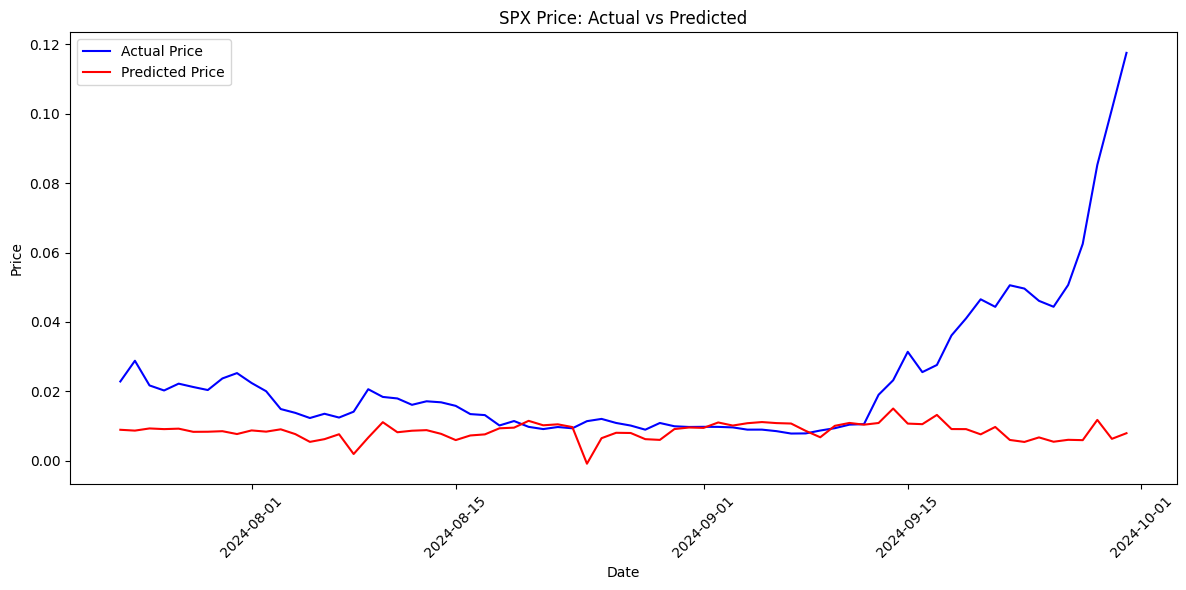

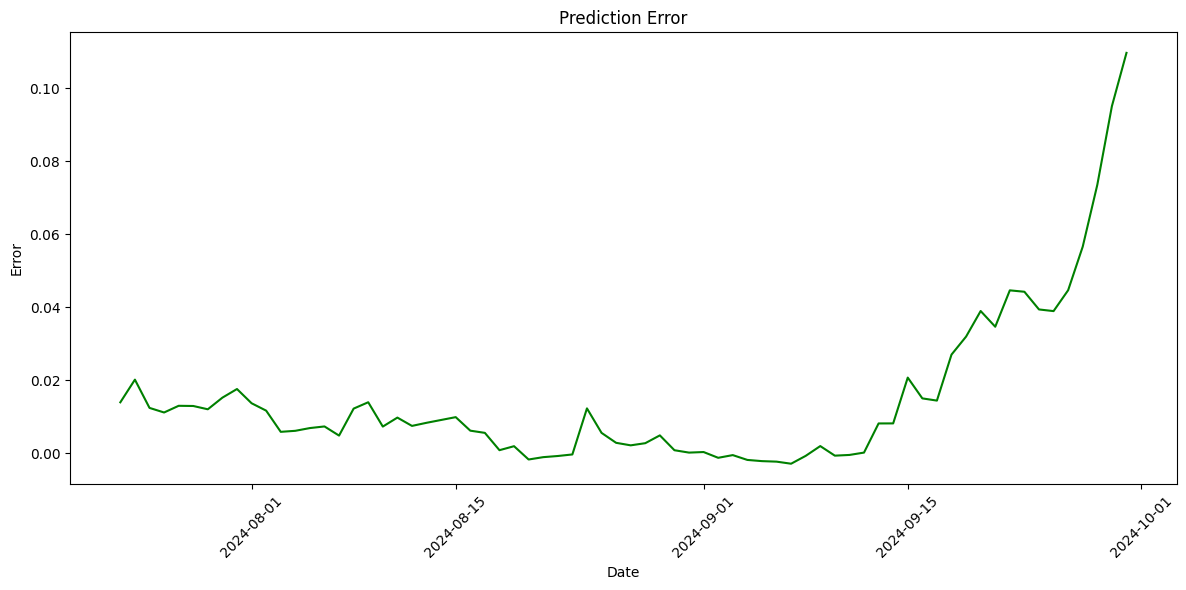

Mean Absolute Percentage Error: 47.93%
Correlation between actual and predicted: -0.1249

Sample predictions:
Date: 2024-07-23, Actual: 0.02, Predicted: 0.01
Date: 2024-07-24, Actual: 0.03, Predicted: 0.01
Date: 2024-07-25, Actual: 0.02, Predicted: 0.01
Date: 2024-07-26, Actual: 0.02, Predicted: 0.01
Date: 2024-07-27, Actual: 0.02, Predicted: 0.01


In [14]:
# Calculate RMSE
rmse = np.sqrt(np.mean((test_predictions - y_test)**2))
print(f'RMSE: {rmse:.4f}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(df.index[-len(y_test):], test_predictions, label='Predicted Price', color='red')
plt.title('SPX Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot prediction error
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test - test_predictions, color='green')
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print additional metrics
mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

correlation = np.corrcoef(y_test, test_predictions)[0, 1]
print(f'Correlation between actual and predicted: {correlation:.4f}')

# Print some sample predictions
print("\nSample predictions:")
for i in range(min(5, len(y_test))):
    print(f"Date: {df.index[-len(y_test):][i].date()}, Actual: {y_test[i]:.2f}, Predicted: {test_predictions[i]:.2f}")